In [1]:
from transformers import AutoModelForZeroShotObjectDetection, AutoProcessor
import torch
from PIL import Image

# Load GroundingDINO from HF (zero-shot object detection head)
model = AutoModelForZeroShotObjectDetection.from_pretrained(
    "IDEA-Research/grounding-dino-base", trust_remote_code=True
)
processor = AutoProcessor.from_pretrained(
    "IDEA-Research/grounding-dino-base", trust_remote_code=True
)

image = Image.open("cat.png").convert("RGB")
inputs = processor(images=image, text="object", return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)


/home/pc/dev/group-1/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pc/dev/group-1/venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [2]:
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont
import torch


def visualize_detections(image, inputs, outputs, box_threshold: float = 0.15, text_threshold: float = 0.1):
    # Post-process detections to image size
    width, height = image.size
    target_sizes = [(height, width)]

    # Try compatible post-processing methods across GroundingDINO variants
    last_error = None
    results = None
    for method_name in [
        "post_process_grounding_object_detection",
        "post_process_grounded_object_detection",
        "post_process_object_detection",
    ]:
        fn = getattr(processor, method_name, None)
        if fn is None:
            continue
        try:
            results = fn(
                outputs,
                inputs["input_ids"],
                box_threshold=box_threshold,
                text_threshold=text_threshold,
                target_sizes=target_sizes,
            )
            break
        except Exception as e:
            last_error = e
            results = None

    if results is None:
        raise RuntimeError(f"Failed to post-process detections: {last_error}")

    result = results[0]
    boxes = result["boxes"] if "boxes" in result else result.get("boxes_xyxy", None)
    scores = result.get("scores", None)
    labels = result.get("labels", result.get("phrases", []))

    # Convert tensors to Python lists for iteration
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.detach().cpu().tolist()
    if boxes is None:
        boxes = []
    if isinstance(scores, torch.Tensor):
        scores = scores.detach().cpu().tolist()
    if scores is None:
        scores = []

    # Draw results
    vis_image = image.copy()
    draw = ImageDraw.Draw(vis_image)
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 16)
    except Exception:
        font = ImageFont.load_default()

    if len(boxes) == 0:
        print("No detections above thresholds.")
    else:
        for box, score, label in zip(boxes, scores, labels):
            x0, y0, x1, y1 = [float(v) for v in box]
            # Clamp to image boundaries
            x0 = max(0, min(x0, width - 1))
            y0 = max(0, min(y0, height - 1))
            x1 = max(0, min(x1, width - 1))
            y1 = max(0, min(y1, height - 1))
            draw.rectangle([x0, y0, x1, y1], outline="red", width=3)
            caption = f"{label} {score:.2f}"
            # Compute text background size
            try:
                bbox = draw.textbbox((0, 0), caption, font=font)
                text_w, text_h = bbox[2] - bbox[0], bbox[3] - bbox[1]
            except Exception:
                text_w, text_h = draw.textsize(caption, font=font)
            draw.rectangle([x0, max(0, y0 - text_h), x0 + text_w, y0], fill="red")
            draw.text((x0, max(0, y0 - text_h)), caption, fill="white", font=font)

    plt.figure(figsize=(8, 8))
    plt.imshow(vis_image)
    plt.axis("off")
    plt.show()

    return vis_image


Segmentation took 5.244 seconds for cat.png

Visualizing: cat.png


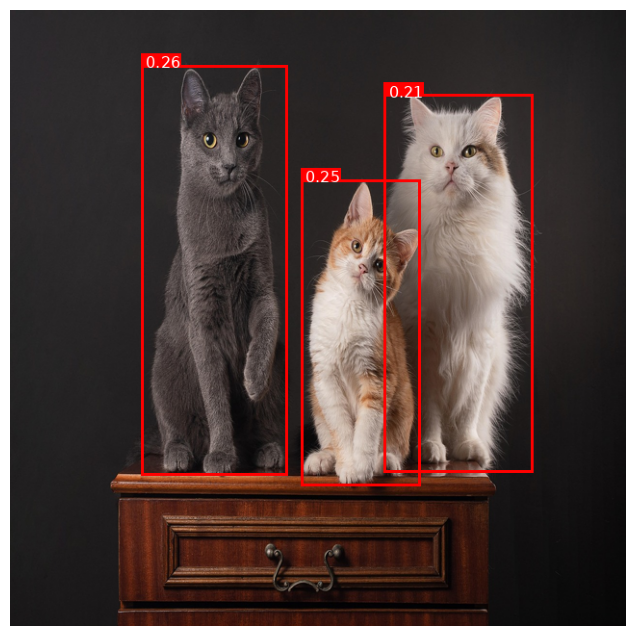

Segmentation took 5.395 seconds for cat2.jpg

Visualizing: cat2.jpg


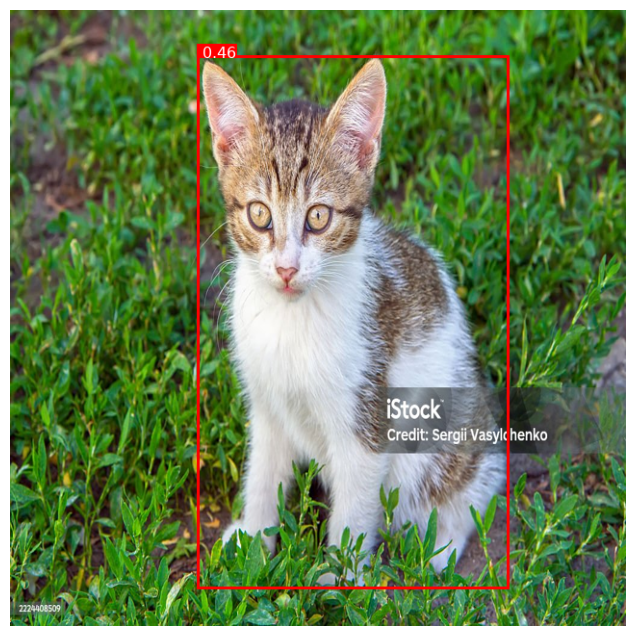

Segmentation took 5.402 seconds for cat3.webp

Visualizing: cat3.webp


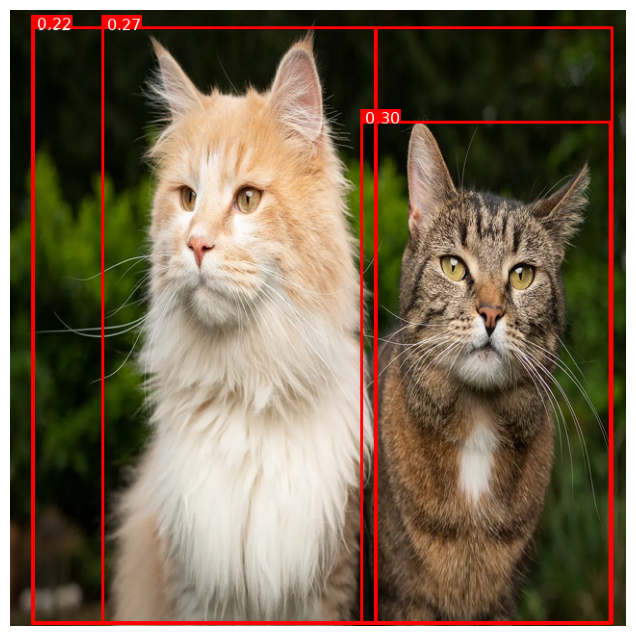

Segmentation took 4.844 seconds for fictional_cat.png

Visualizing: fictional_cat.png


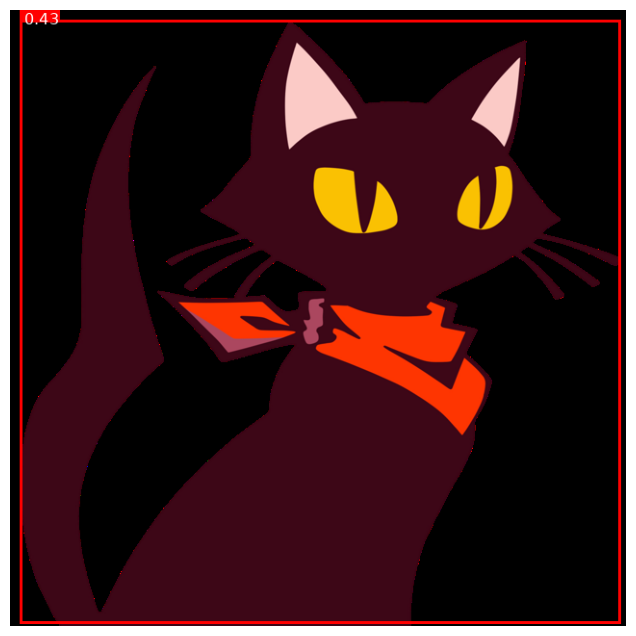

Segmentation took 5.231 seconds for art_cat.webp

Visualizing: art_cat.webp


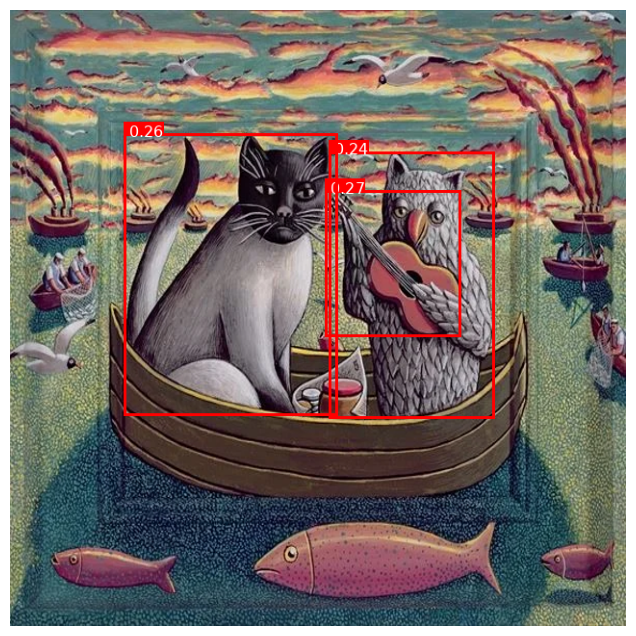

Segmentation took 5.447 seconds for person.webp

Visualizing: person.webp


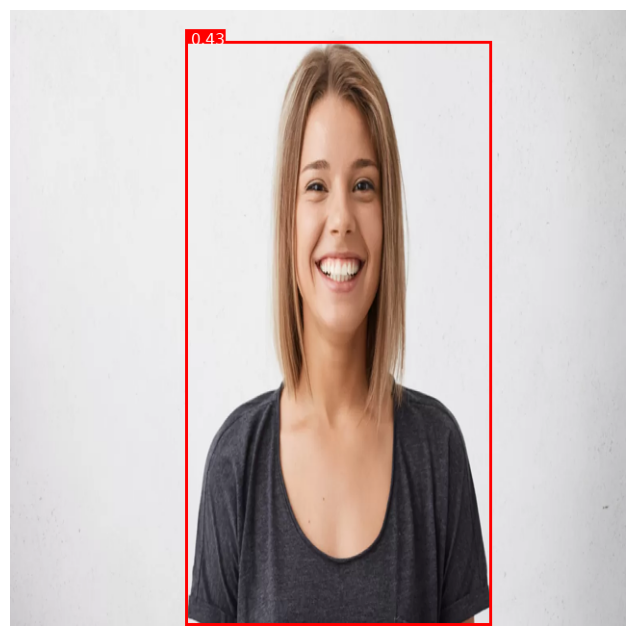

Segmentation took 5.557 seconds for fictional_person.jpg

Visualizing: fictional_person.jpg


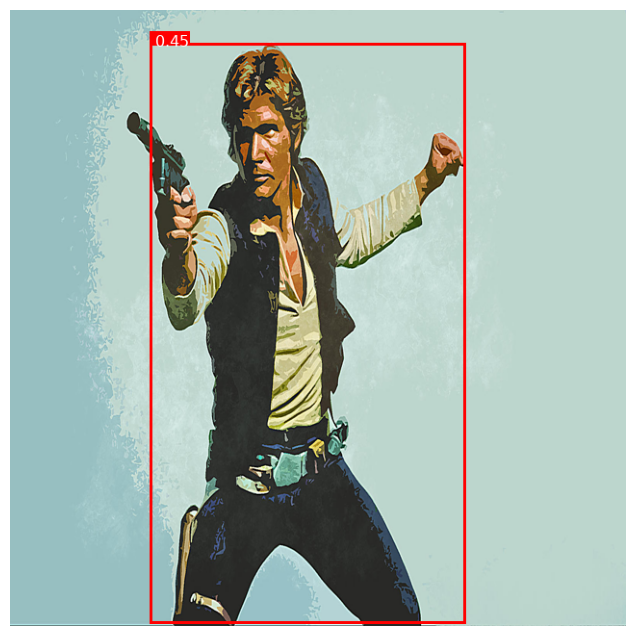

In [17]:
# Batch inference and visualization over a list of image paths
from pathlib import Path
import time

image_paths = [
    "cat.png",
    "cat2.jpg",
    "cat3.webp",
    "fictional_cat.png",
    "art_cat.webp",
    "person.webp",
    "fictional_person.jpg"
]

text_query = "one cat"
box_threshold = 0.2
text_threshold = 0.5

for p in image_paths:
    p = str(p)
    if not Path(p).exists():
        print(f"Skipping missing image: {p}")
        continue
    image = Image.open(p).resize((640, 640)).convert("RGB")
    inputs = processor(images=image, text=text_query, return_tensors="pt")
    start_time = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    elapsed = time.time() - start_time
    print(f"Segmentation took {elapsed:.3f} seconds for {p}")
    print(f"\nVisualizing: {p}")
    _ = visualize_detections(image, inputs, outputs, box_threshold, text_threshold)
